---

### 1. 환경 설정 및 라이브러리 Import


---

In [2]:
import os
import sys
from pathlib import Path
from glob import glob

import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import warnings
warnings.filterwarnings('ignore')

# matplotlib 한글 폰트 설정
import platform
import matplotlib.font_manager as fm

# 한글 폰트 찾기
def setup_korean_font():
    """한글 폰트 설정"""
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

setup_korean_font()

# 프로젝트 루트 경로 설정
project_root = Path.cwd()
sys.path.insert(0, str(project_root))

# GPU 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"사용 디바이스: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


사용 디바이스: cuda
GPU: NVIDIA GeForce RTX 5070
GPU 메모리: 11.9 GB


---

### 2. 설정 및 경로 설정

---

#### 아래 경로들을 실제 환경에 맞게 수정하세요.

In [3]:
# ===== 설정 경로 =====
CONFIG_PATH = "config/default.yaml"  # 설정 파일 경로
CHECKPOINT_PATH = "checkpoints/bottle/1900"  # 체크포인트 경로

# ===== 입력/출력 경로 =====
INPUT_IMAGE = "data/input/bottle/broken_large (1).png"  # 복원할 불량 이미지
INPUT_MASK = None  # 마스크 이미지 (선택사항, None이면 자동 생성)
OUTPUT_DIR = "data/output/bottle"  # 결과 저장 디렉토리

# ===== 복원 옵션 =====
USE_MASK = False  # 마스크 기반 복원 사용 여부

print("설정 확인:")
print(f"  설정 파일: {CONFIG_PATH}")
print(f"  체크포인트: {CHECKPOINT_PATH}")
print(f"  입력 이미지: {INPUT_IMAGE}")
print(f"  마스크: {INPUT_MASK if INPUT_MASK else '자동 생성'}")
print(f"  출력 디렉토리: {OUTPUT_DIR}")
print(f"  마스크 사용: {USE_MASK}")


설정 확인:
  설정 파일: config/default.yaml
  체크포인트: checkpoints/bottle/1900
  입력 이미지: data/input/bottle/broken_large (1).png
  마스크: 자동 생성
  출력 디렉토리: data/output/bottle
  마스크 사용: False


---

### 3. 복원기 초기화 및 모델 로드




---

#### MDPSReconstructor 클래스를 사용하여 복원기를 초기화하고 체크포인트를 로드합니다.

In [4]:
from reconstruct_defect import MDPSReconstructor

# 복원기 초기화
print("복원기 초기화 중...")
reconstructor = MDPSReconstructor(
    config_path=CONFIG_PATH if os.path.exists(CONFIG_PATH) else None,
    checkpoint_path=CHECKPOINT_PATH if os.path.exists(CHECKPOINT_PATH) else None
)

if reconstructor.checkpoint_loaded:
    print("✅ 모델 로드 완료!")
    print(f"  이미지 크기: {reconstructor.config.data.image_size}x{reconstructor.config.data.image_size}")
    print(f"  Diffusion 스텝: {reconstructor.config.model.test_steps}")
    print(f"  가이던스 강도 (w): {reconstructor.config.model.w}")
else:
    print("⚠️ 체크포인트를 찾을 수 없습니다.")
    print(f"  경로: {CHECKPOINT_PATH}")
    print("  체크포인트 경로를 확인하세요.")


복원기 초기화 중...
GPU 사용: NVIDIA GeForce RTX 5070
체크포인트 로딩: checkpoints/bottle/1900
모델 로드 완료!
✅ 모델 로드 완료!
  이미지 크기: 256x256
  Diffusion 스텝: 200
  가이던스 강도 (w): 100


---

### 4. 입력 이미지 로드 및 확인

---

#### 복원할 불량 이미지를 로드하고 확인합니다.

이미지 로드: data/input/bottle/broken_large (1).png
  이미지 크기: torch.Size([1, 3, 256, 256])


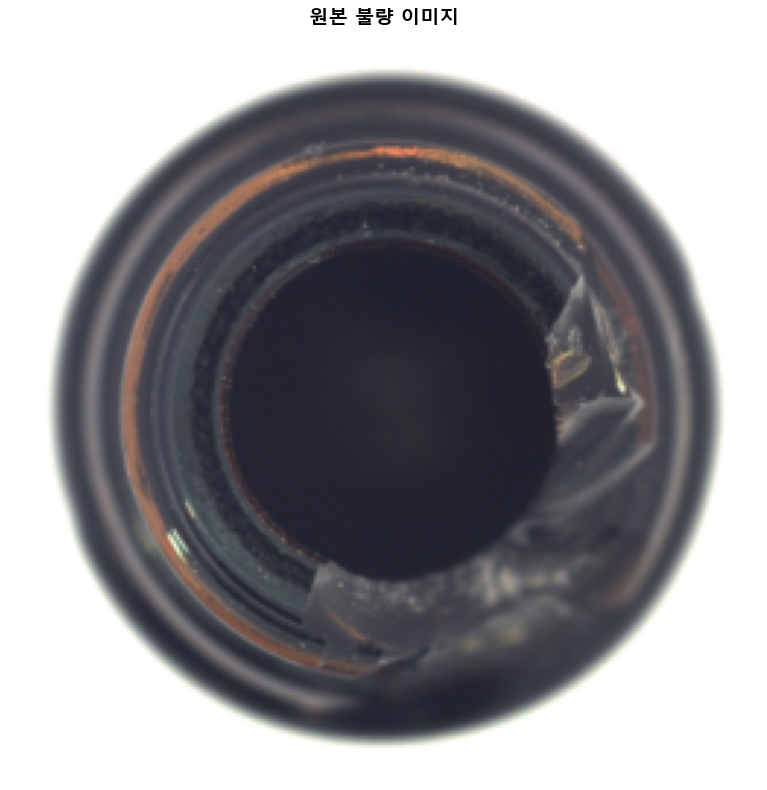

In [5]:
# 이미지 로드
if os.path.exists(INPUT_IMAGE):
    print(f"이미지 로드: {INPUT_IMAGE}")
    image_tensor = reconstructor.load_image(INPUT_IMAGE)
    print(f"  이미지 크기: {image_tensor.shape}")
    
    # 이미지 시각화
    def denormalize(tensor):
        return ((tensor + 1) / 2).clamp(0, 1)
    
    original_img = denormalize(image_tensor[0]).permute(1, 2, 0).cpu().numpy()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(original_img)
    plt.title("원본 불량 이미지", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print(f"❌ 이미지를 찾을 수 없습니다: {INPUT_IMAGE}")
    image_tensor = None


---

### 5. 마스크 로드 (선택사항)

---

#### 외부 마스크가 있으면 로드합니다. 없으면 자동으로 생성됩니다.

In [6]:
external_mask = None

if INPUT_MASK and os.path.exists(INPUT_MASK):
    print(f"마스크 로드: {INPUT_MASK}")
    external_mask = reconstructor.load_mask(INPUT_MASK)
    print(f"  마스크 크기: {external_mask.shape}")
    
    # 마스크 시각화
    mask_img = external_mask[0, 0].cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(mask_img, cmap='gray')
    plt.title("외부 마스크 (흰색: 불량 영역)", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("외부 마스크 없음 - 자동으로 마스크를 생성합니다.")


외부 마스크 없음 - 자동으로 마스크를 생성합니다.


---

### 6. 불량 이미지 복원 실행

---

In [7]:
if image_tensor is not None and reconstructor.checkpoint_loaded:
    print("복원 시작...")
    print("이 과정은 시간이 걸릴 수 있습니다. 잠시만 기다려주세요...\n")
    
    # 복원 실행
    results = reconstructor.reconstruct(
        image_tensor, 
        use_mask=USE_MASK,
        external_mask=external_mask
    )
    
    print("✅ 복원 완료!")
    print(f"  원본 이미지: {results['original'].shape}")
    if results['reconstructed'] is not None:
        print(f"  복원 이미지: {results['reconstructed'].shape}")
    if results['anomaly_map'] is not None:
        print(f"  Anomaly Map: {results['anomaly_map'].shape}")
    if results['mask'] is not None:
        print(f"  마스크: {results['mask'].shape}")
else:
    print("❌ 이미지 또는 모델이 로드되지 않았습니다.")
    results = None


복원 시작...
이 과정은 시간이 걸릴 수 있습니다. 잠시만 기다려주세요...

✅ 복원 완료!
  원본 이미지: torch.Size([1, 3, 256, 256])
  복원 이미지: torch.Size([1, 3, 256, 256])
  Anomaly Map: torch.Size([1, 1, 256, 256])


---

### 7. 결과 시각화

---

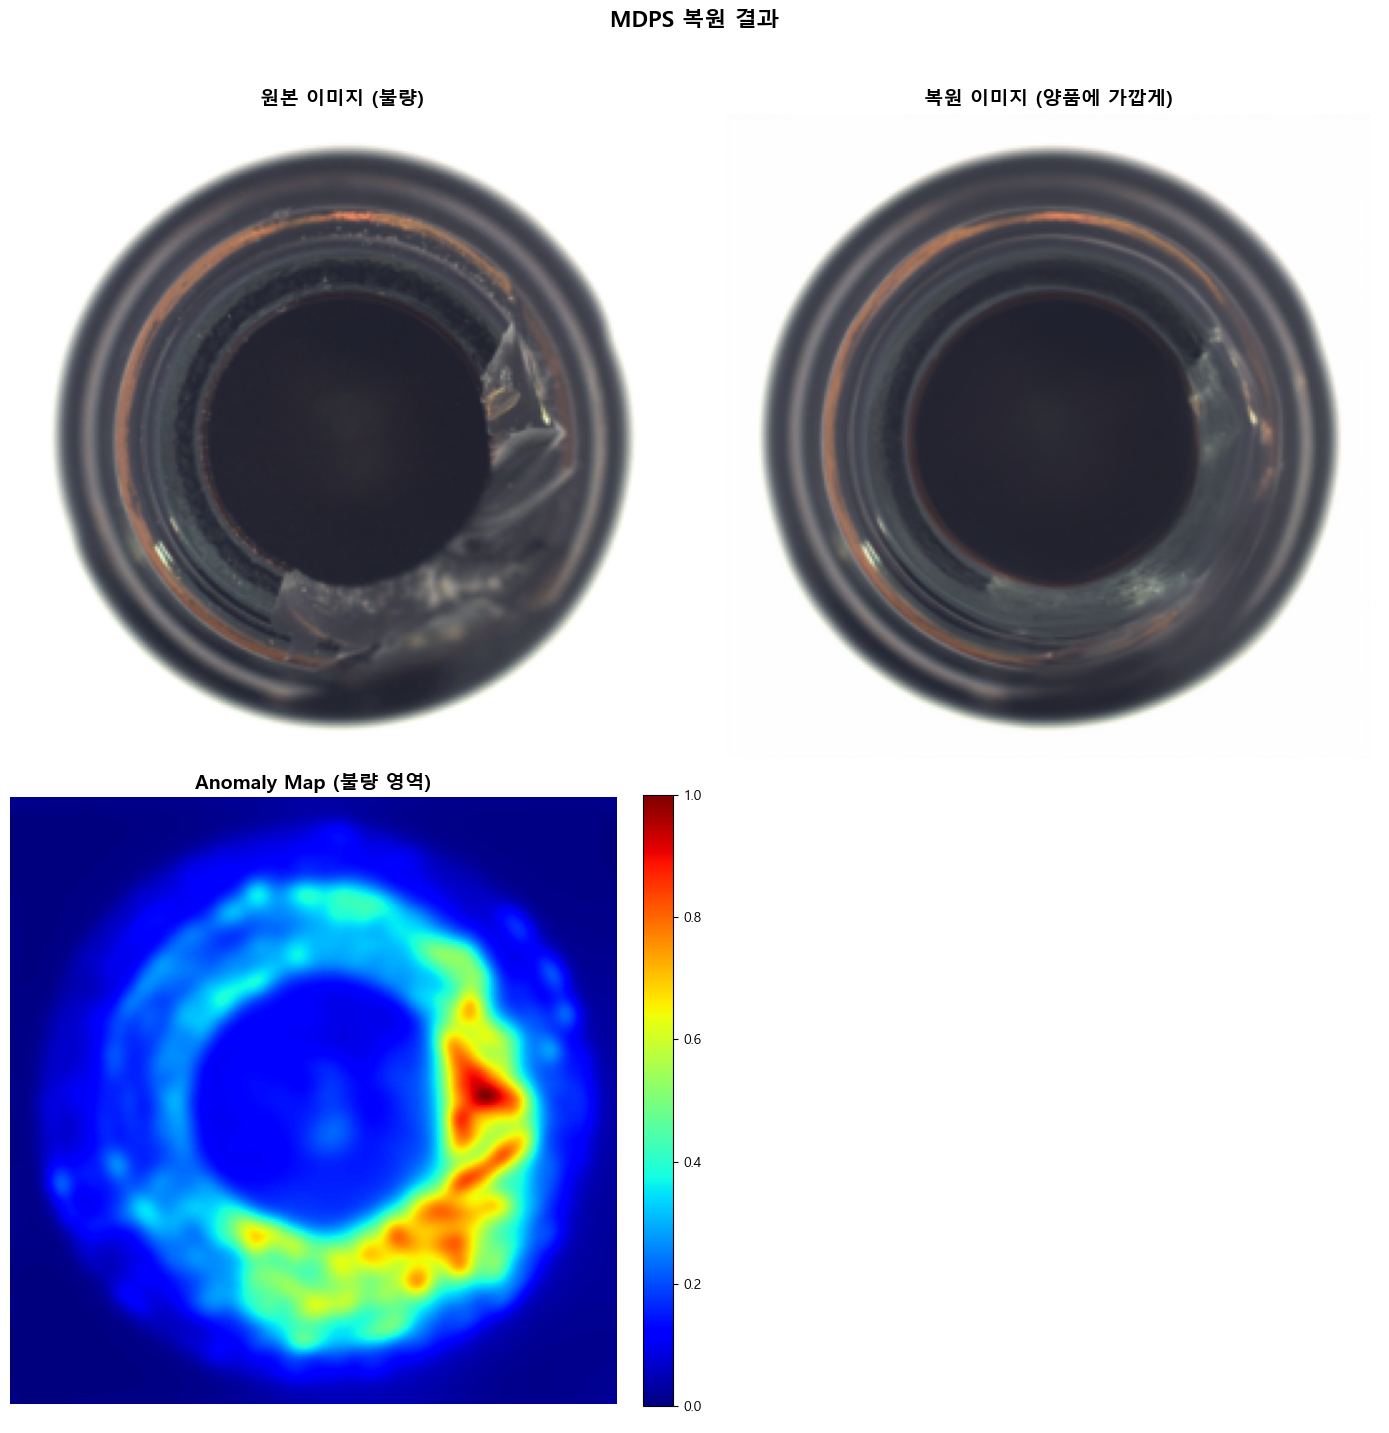

In [8]:
if results is not None:
    def denormalize(tensor):
        return ((tensor + 1) / 2).clamp(0, 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    
    # 1. 원본 이미지
    original = denormalize(results['original'][0]).permute(1, 2, 0).cpu().numpy()
    axes[0, 0].imshow(original)
    axes[0, 0].set_title('원본 이미지 (불량)', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')
    
    # 2. 복원 이미지
    if results['reconstructed'] is not None:
        reconstructed = denormalize(results['reconstructed'][0]).permute(1, 2, 0).cpu().numpy()
        axes[0, 1].imshow(reconstructed)
        axes[0, 1].set_title('복원 이미지 (양품에 가깝게)', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')
    
    # 3. Anomaly Map
    if results['anomaly_map'] is not None:
        anomaly_map = results['anomaly_map'][0, 0].cpu().numpy()
        anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-8)
        im = axes[1, 0].imshow(anomaly_map, cmap='jet')
        axes[1, 0].set_title('Anomaly Map (불량 영역)', fontsize=14, fontweight='bold')
        plt.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04)
    axes[1, 0].axis('off')
    
    # 4. 마스크
    if results['mask'] is not None:
        mask = results['mask'][0, 0].cpu().numpy()
        axes[1, 1].imshow(mask, cmap='gray')
        axes[1, 1].set_title('불량 마스크 (흰색: 불량 영역)', fontsize=14, fontweight='bold')
    axes[1, 1].axis('off')
    
    plt.suptitle('MDPS 복원 결과', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("결과가 없습니다.")


---

### 8. 상세 비교 시각화

---

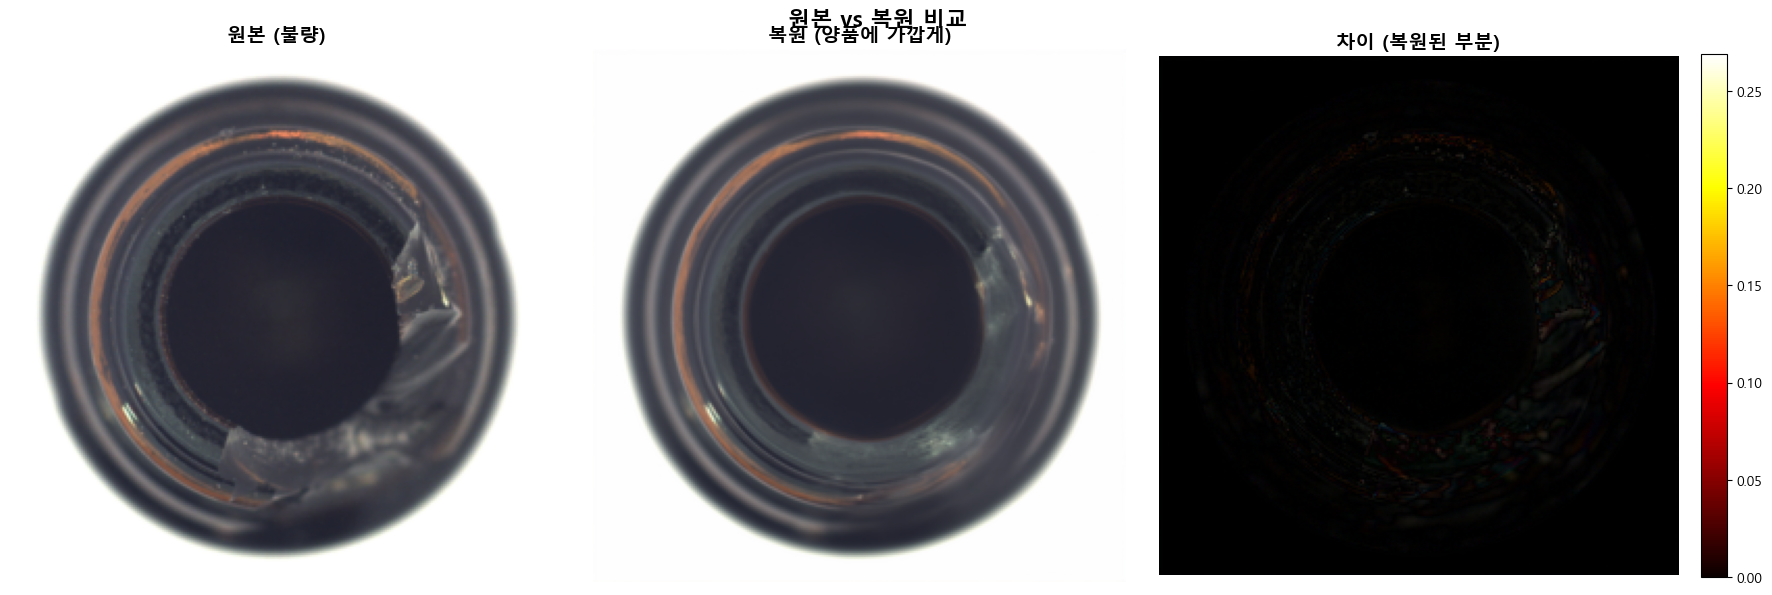

In [9]:
if results is not None and results['reconstructed'] is not None:
    def denormalize(tensor):
        return ((tensor + 1) / 2).clamp(0, 1)
    
    original = denormalize(results['original'][0]).permute(1, 2, 0).cpu().numpy()
    reconstructed = denormalize(results['reconstructed'][0]).permute(1, 2, 0).cpu().numpy()
    
    # 차이 이미지
    diff = np.abs(original - reconstructed)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(original)
    axes[0].set_title('원본 (불량)', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(reconstructed)
    axes[1].set_title('복원 (양품에 가깝게)', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    im = axes[2].imshow(diff, cmap='hot')
    axes[2].set_title('차이 (복원된 부분)', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    axes[2].axis('off')
    
    plt.suptitle('원본 vs 복원 비교', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("복원 결과가 없습니다.")


---

### 9. 결과 저장

---

In [10]:
if results is not None:
    # 파일명 생성
    filename = Path(INPUT_IMAGE).stem
    
    # 결과 저장
    reconstructor.save_results(results, OUTPUT_DIR, filename)
    
    print(f"\n✅ 결과 저장 완료!")
    print(f"  저장 위치: {OUTPUT_DIR}")
    print(f"\n생성된 파일:")
    saved_files = glob(os.path.join(OUTPUT_DIR, f"{filename}*"))
    for f in saved_files:
        print(f"  - {f}")
else:
    print("저장할 결과가 없습니다.")


결과 저장 완료: data/output/bottle

✅ 결과 저장 완료!
  저장 위치: data/output/bottle

생성된 파일:
  - data/output/bottle\broken_large (1)_anomaly_map.png
  - data/output/bottle\broken_large (1)_comparison.png
  - data/output/bottle\broken_large (1)_original.png
  - data/output/bottle\broken_large (1)_reconstructed.png


---

### 10. 배치 처리 (여러 이미지를 한 번에 처리)

---

In [12]:
# 배치 처리 설정 (주석 해제하여 사용)
BATCH_INPUT_DIR = "data/input/bottle"  # 입력 이미지 폴더
BATCH_MASK_DIR = None  # 마스크 폴더 (선택사항)
BATCH_OUTPUT_DIR = "data/output/bottle"  # 출력 폴더

# 배치 처리 실행 (주석 해제)
if reconstructor.checkpoint_loaded:
    print(f"\n배치 처리 시작: {BATCH_INPUT_DIR}")
    
    image_files = glob(os.path.join(BATCH_INPUT_DIR, "*.png")) + \
                  glob(os.path.join(BATCH_INPUT_DIR, "*.jpg"))
    
    print(f"발견된 이미지: {len(image_files)}개\n")
    
    for idx, image_file in enumerate(image_files, 1):
        print(f"[{idx}/{len(image_files)}] 처리 중: {Path(image_file).name}")
        
        try:
            # 마스크 찾기
            mask_file = None
            if BATCH_MASK_DIR:
                img_stem = Path(image_file).stem
                for pattern in [f"{img_stem}_mask.png", f"{img_stem}.png"]:
                    possible_mask = os.path.join(BATCH_MASK_DIR, pattern)
                    if os.path.exists(possible_mask):
                        mask_file = possible_mask
                        break
            
            # 복원
            results = reconstructor.reconstruct_from_file(
                image_file, 
                mask_path=mask_file,
                use_mask=USE_MASK
            )
            
            # 저장
            filename = Path(image_file).stem
            reconstructor.save_results(results, BATCH_OUTPUT_DIR, filename)
            
            print(f"  ✅ 완료\n")
        except Exception as e:
            print(f"  ❌ 오류: {e}\n")
            continue
    
    print("배치 처리 완료!")
else:
    print("모델이 로드되지 않았습니다.")

print("배치 처리를 사용하려면 위 코드의 주석을 해제하세요.")



배치 처리 시작: data/input/bottle
발견된 이미지: 42개

[1/42] 처리 중: broken_large (1).png
결과 저장 완료: data/output/bottle
  ✅ 완료

[2/42] 처리 중: broken_large (10).png
결과 저장 완료: data/output/bottle
  ✅ 완료

[3/42] 처리 중: broken_large (11).png
결과 저장 완료: data/output/bottle
  ✅ 완료

[4/42] 처리 중: broken_large (12).png
결과 저장 완료: data/output/bottle
  ✅ 완료

[5/42] 처리 중: broken_large (13).png
결과 저장 완료: data/output/bottle
  ✅ 완료

[6/42] 처리 중: broken_large (14).png
결과 저장 완료: data/output/bottle
  ✅ 완료

[7/42] 처리 중: broken_large (15).png
결과 저장 완료: data/output/bottle
  ✅ 완료

[8/42] 처리 중: broken_large (16).png
결과 저장 완료: data/output/bottle
  ✅ 완료

[9/42] 처리 중: broken_large (17).png
결과 저장 완료: data/output/bottle
  ✅ 완료

[10/42] 처리 중: broken_large (18).png
결과 저장 완료: data/output/bottle
  ✅ 완료

[11/42] 처리 중: broken_large (19).png
결과 저장 완료: data/output/bottle
  ✅ 완료

[12/42] 처리 중: broken_large (2).png
결과 저장 완료: data/output/bottle
  ✅ 완료

[13/42] 처리 중: broken_large (20).png
결과 저장 완료: data/output/bottle
  ✅ 완료

[14/42] 처리 중: broke

## 12. Epoch별 FID 점수 계산

각 epoch(500, 1000, 1500)별로 복원된 이미지의 FID (Fréchet Inception Distance) 점수를 계산합니다.

- **FID**: 낮을수록 좋음 (원본 이미지와 복원 이미지 간의 유사도)
- 각 epoch별 output 폴더에서 `original`과 `reconstructed` 폴더를 자동으로 찾아 비교합니다.

In [ ]:
# FID/IS 계산 라이브러리
from pytorch_fid import fid_score
from pathlib import Path
import shutil
import json
import numpy as np
from PIL import Image
from glob import glob

# IS 계산을 위한 라이브러리 확인
try:
    import torchmetrics
    from torchmetrics.image import InceptionScore
    IS_AVAILABLE = True
except ImportError:
    IS_AVAILABLE = False
    print("⚠️ torchmetrics가 설치되지 않아 IS 계산을 건너뜁니다.")
    print("   설치 명령어: pip install torchmetrics[image]")

def get_image_directories(output_dir):
    """output 폴더 내부에서 original과 reconstructed 이미지 경로 찾기
    
    파일 이름에 'original' 또는 'reconstructed'가 포함된 모든 이미지 파일을 찾아
    각각의 폴더로 분류합니다.
    """
    output_path = Path(output_dir)
    original_dir = output_path / "original"
    reconstructed_dir = output_path / "reconstructed"
    
    # 지원하는 이미지 확장자
    image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.PNG', '*.JPG', '*.JPEG']
    
    # original 폴더/파일 찾기
    if original_dir.exists() and original_dir.is_dir():
        # 폴더가 있으면 그대로 사용
        count = sum(len(list(original_dir.glob(ext))) for ext in image_extensions)
        print(f"✅ original 폴더 발견: {count}개 파일")
        original_path = str(original_dir)
    else:
        # 폴더가 없으면 이름에 'original'이 포함된 모든 이미지 파일 찾기
        original_files = []
        for ext in image_extensions:
            # 파일 이름에 'original'이 포함된 파일 찾기 (대소문자 구분 없음)
            all_files = list(output_path.glob(ext))
            for file in all_files:
                if 'original' in file.name.lower():
                    original_files.append(file)
        
        if original_files:
            # 임시 폴더 생성
            original_dir.mkdir(exist_ok=True)
            for orig_file in original_files:
                # Windows에서는 심볼릭 링크가 복잡하므로 복사 (필요시 수정 가능)
                if not (original_dir / orig_file.name).exists():
                    shutil.copy2(orig_file, original_dir / orig_file.name)
            print(f"✅ original 폴더 생성: {len(original_files)}개 파일")
            original_path = str(original_dir)
        else:
            raise FileNotFoundError(f"원본 이미지를 찾을 수 없습니다: {output_dir} (이름에 'original'이 포함된 이미지 파일이 없습니다)")
    
    # reconstructed 폴더/파일 찾기
    if reconstructed_dir.exists() and reconstructed_dir.is_dir():
        # 폴더가 있으면 그대로 사용
        count = sum(len(list(reconstructed_dir.glob(ext))) for ext in image_extensions)
        print(f"✅ reconstructed 폴더 발견: {count}개 파일")
        reconstructed_path = str(reconstructed_dir)
    else:
        # 폴더가 없으면 이름에 'reconstructed'가 포함된 모든 이미지 파일 찾기
        reconstructed_files = []
        for ext in image_extensions:
            # 파일 이름에 'reconstructed'가 포함된 파일 찾기 (대소문자 구분 없음)
            all_files = list(output_path.glob(ext))
            for file in all_files:
                if 'reconstructed' in file.name.lower():
                    reconstructed_files.append(file)
        
        if reconstructed_files:
            # 임시 폴더 생성
            reconstructed_dir.mkdir(exist_ok=True)
            for recon_file in reconstructed_files:
                if not (reconstructed_dir / recon_file.name).exists():
                    shutil.copy2(recon_file, reconstructed_dir / recon_file.name)
            print(f"✅ reconstructed 폴더 생성: {len(reconstructed_files)}개 파일")
            reconstructed_path = str(reconstructed_dir)
        else:
            raise FileNotFoundError(f"복원 이미지를 찾을 수 없습니다: {output_dir} (이름에 'reconstructed'가 포함된 이미지 파일이 없습니다)")
    
    return original_path, reconstructed_path


def calculate_fid(original_dir, reconstructed_dir, device='cuda', batch_size=32):
    """FID 점수 계산"""
    # 변수명 충돌 방지를 위해 함수 내부에서 import
    from pytorch_fid import fid_score as fid_module
    fid_value = fid_module.calculate_fid_given_paths(
        [original_dir, reconstructed_dir],
        batch_size=batch_size,
        device=device,
        dims=2048,
        num_workers=0
    )
    return fid_value


def calculate_is(reconstructed_dir, device='cuda', batch_size=32):
    """IS 점수 계산"""
    if not IS_AVAILABLE:
        return None
    
    # 이미지 파일 목록
    image_files = sorted(glob(str(Path(reconstructed_dir) / "*.png")) + 
                       glob(str(Path(reconstructed_dir) / "*.jpg")))
    
    if len(image_files) == 0:
        return None
    
    # 이미지 로드 및 전처리
    images = []
    for path in image_files:
        img = Image.open(path).convert('RGB')
        img = img.resize((299, 299))
        img_array = np.array(img).astype(np.uint8)
        images.append(img_array)
    
    # 배치로 나누기
    batches = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch_array = np.stack(batch)
        batch_tensor = torch.from_numpy(batch_array).permute(0, 3, 1, 2).float()
        batches.append(batch_tensor.to(device))
    
    # IS 계산
    is_metric = InceptionScore(normalize=True).to(device)
    for batch in batches:
        is_metric.update(batch)
    
    # compute()는 tuple (mean, std)를 반환할 수 있음
    result = is_metric.compute()
    if isinstance(result, tuple):
        is_score = result[0].item()  # mean 값
    else:
        is_score = result.item()
    return is_score


def evaluate_reconstruction(output_dir):
    try:
        print("=" * 60)
        print("단일 폴더 FID/IS 계산")
        print("=" * 60)
        print(f"Output 폴더: {OUTPUT_DIR}\n")
        # original과 reconstructed 폴더 설정
        original_dir, reconstructed_dir = get_image_directories(output_dir)
        
        # FID 계산
        print("\nFID 계산 중...")
        fid_score = calculate_fid(original_dir, reconstructed_dir, device=device, batch_size=32)
        
        # IS 계산
        is_score = None
        if IS_AVAILABLE:
            print("\nIS 계산 중...")
            is_score = calculate_is(reconstructed_dir, device=device, batch_size=32)
        
        # 결과 출력
        print("\n" + "=" * 60)
        print("평가 결과")
        print("=" * 60)
        print(f"FID Score: {fid_score:.4f} (낮을수록 좋음)")
        if is_score is not None:
            print(f"IS Score: {is_score:.4f} (높을수록 좋음)")
        print("=" * 60)
        
        # 결과 저장
        results_dict = {
            'FID': float(fid_score),
            'output_dir': output_dir,
            'original_dir': original_dir,
            'reconstructed_dir': reconstructed_dir
        }
        if is_score is not None:
            results_dict['IS'] = float(is_score)
        
        output_file = Path(output_dir) / "evaluation_metrics.json"
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(results_dict, f, indent=2, ensure_ascii=False)
        print(f"\n결과 저장: {output_file}")
        
    except FileNotFoundError as e:
        print(f"❌ 오류: {e}")
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        import traceback
        traceback.print_exc()


단일 폴더 FID/IS 계산
Output 폴더: data/output/1500



In [26]:
output_dir = "data/output/500"
evaluate_reconstruction(output_dir)

✅ original 폴더 발견: 40개 파일
✅ reconstructed 폴더 발견: 40개 파일

FID 계산 중...


100%|██████████| 1/1 [00:00<00:00, 15.99it/s]


100%|██████████| 1/1 [00:00<00:00, 17.74it/s]



IS 계산 중...

평가 결과
FID Score: 76.0078 (낮을수록 좋음)
IS Score: 1.1980 (높을수록 좋음)

결과 저장: data\output\500\evaluation_metrics.json


In [ ]:
output_dir = "data/output/1000"
evaluate_reconstruction(output_dir)

In [ ]:
output_dir = "data/output/1500"
evaluate_reconstruction(output_dir)

## 13. Epoch별 FID 점수 계산

여러 epoch(500, 1000, 1500)별로 복원된 이미지의 FID 점수를 계산합니다.

- 각 epoch별 output 폴더에서 `original`과 `reconstructed` 폴더를 자동으로 찾아 비교합니다.
- 결과를 비교하여 최적의 epoch를 찾을 수 있습니다.


In [21]:
# ===== Epoch별 FID 점수 계산 =====
BASE_OUTPUT_DIR = "data/output"  # 기본 output 폴더
EPOCHS = [500, 1000, 1500]  # 평가할 epoch 목록

print("=" * 60)
print("Epoch별 FID 점수 계산")
print("=" * 60)

results = {}

for epoch in EPOCHS:
    print(f"\n[Epoch {epoch}]")
    print("-" * 60)
    
    # epoch별 output 폴더 경로
    # 예: data/output/bottle/500, data/output/bottle/1000 등
    output_dir = f"{BASE_OUTPUT_DIR}/{epoch}"
    
    try:
        # original과 reconstructed 폴더 설정
        original_dir, reconstructed_dir = get_image_directories(output_dir)
        
        # FID 계산
        print(f"FID 계산 중...")
        fid_score = calculate_fid(original_dir, reconstructed_dir, device=device, batch_size=32)
        
        results[epoch] = {
            'FID': float(fid_score),
            'output_dir': output_dir
        }
        
        print(f"✅ Epoch {epoch}: FID = {fid_score:.4f}")
        
    except FileNotFoundError as e:
        print(f"❌ Epoch {epoch}: {e}")
        results[epoch] = {'FID': None, 'error': str(e)}
    except Exception as e:
        print(f"❌ Epoch {epoch}: 오류 발생 - {e}")
        results[epoch] = {'FID': None, 'error': str(e)}

# 결과 출력
print("\n" + "=" * 60)
print("전체 결과")
print("=" * 60)
for epoch in EPOCHS:
    if results[epoch].get('FID') is not None:
        print(f"Epoch {epoch:4d}: FID = {results[epoch]['FID']:.4f}")
    else:
        print(f"Epoch {epoch:4d}: 계산 실패 - {results[epoch].get('error', '알 수 없는 오류')}")

# 최적 epoch 찾기
valid_results = {k: v for k, v in results.items() if v.get('FID') is not None}
if valid_results:
    best_epoch = min(valid_results.keys(), key=lambda k: valid_results[k]['FID'])
    print(f"\n최적 Epoch: {best_epoch} (FID = {valid_results[best_epoch]['FID']:.4f})")

# 결과 저장
output_file = Path(BASE_OUTPUT_DIR).parent / "fid_results_by_epoch.json"
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)
print(f"\n결과 저장: {output_file}")


Epoch별 FID 점수 계산

[Epoch 500]
------------------------------------------------------------
✅ original 폴더 발견: 40개 파일
✅ reconstructed 폴더 발견: 40개 파일
FID 계산 중...
❌ Epoch 500: 오류 발생 - 'numpy.float64' object has no attribute 'calculate_fid_given_paths'

[Epoch 1000]
------------------------------------------------------------
✅ original 폴더 발견: 84개 파일
✅ reconstructed 폴더 발견: 84개 파일
FID 계산 중...
❌ Epoch 1000: 오류 발생 - 'numpy.float64' object has no attribute 'calculate_fid_given_paths'

[Epoch 1500]
------------------------------------------------------------
✅ original 폴더 발견: 84개 파일
✅ reconstructed 폴더 발견: 84개 파일
FID 계산 중...
❌ Epoch 1500: 오류 발생 - 'numpy.float64' object has no attribute 'calculate_fid_given_paths'

전체 결과
Epoch  500: 계산 실패 - 'numpy.float64' object has no attribute 'calculate_fid_given_paths'
Epoch 1000: 계산 실패 - 'numpy.float64' object has no attribute 'calculate_fid_given_paths'
Epoch 1500: 계산 실패 - 'numpy.float64' object has no attribute 'calculate_fid_given_paths'

결과 저장: data\fid_r